### Post-pandemic biking shifts: 
1) leisure rather than commute. [DONE]
2) new year resolution spike [NONE]
3) temperature curve and cycling; same for rain. perfect temp.
4) temp and rain impact on Mon-Fri vs weekend biking.

In [1]:
import os

# Set environment variables (must be done before importing NumPy/SciPy)
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

print("✅ Environment variables set for this session")
print(f"OMP_NUM_THREADS: {os.environ.get('OMP_NUM_THREADS')}")
print(f"MKL_NUM_THREADS: {os.environ.get('MKL_NUM_THREADS')}")  
print(f"NUMEXPR_NUM_THREADS: {os.environ.get('NUMEXPR_NUM_THREADS')}")

from joblib import Parallel, delayed

✅ Environment variables set for this session
OMP_NUM_THREADS: 8
MKL_NUM_THREADS: 8
NUMEXPR_NUM_THREADS: 8


In [38]:
import io
import pandas as pd

# Reread the CSV with corrected parsing
df = pd.read_csv('Fremont_Bridge_Bicycle_Counter_20250715.csv', 
                 names=['Date', 'Total', 'West_Sidewalk', 'East_Sidewalk'], 
                 header=0)  # Use the first row as header but provide new names

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid date parsing
df.dropna(subset=['Date'], inplace=True)

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Convert count columns to numeric, coercing errors
for col in ['Total', 'West_Sidewalk', 'East_Sidewalk']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values with 0, assuming no traffic is a valid reading
df.fillna(0, inplace=True)

# Convert float columns to integers since counts should be whole numbers
for col in ['Total', 'West_Sidewalk', 'East_Sidewalk']:
    df[col] = df[col].astype(int)

# Extract time-based features
df['Hour'] = df.index.hour
df['Day_of_Week'] = df.index.day_name()
df['Month'] = df.index.month
df['Year'] = df.index.year

# Display the cleaned data and its info
print("Cleaned Data Preview:")
print(df.head())
print("\nCleaned Data Info:")
df.info()

# Display descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

C:\Cache\ipykernel_11208\1793944741.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Cleaned Data Preview:
                     Total  West_Sidewalk  East_Sidewalk  Hour Day_of_Week  \
Date                                                                         
2012-10-02 13:00:00     55              7             48    13     Tuesday   
2012-10-02 14:00:00    130             55             75    14     Tuesday   
2012-10-02 15:00:00    152             81             71    15     Tuesday   
2012-10-02 16:00:00    278            167            111    16     Tuesday   
2012-10-02 17:00:00    563            393            170    17     Tuesday   

                     Month  Year  
Date                              
2012-10-02 13:00:00     10  2012  
2012-10-02 14:00:00     10  2012  
2012-10-02 15:00:00     10  2012  
2012-10-02 16:00:00     10  2012  
2012-10-02 17:00:00     10  2012  

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111696 entries, 2012-10-02 13:00:00 to 2025-06-30 23:00:00
Data columns (total 7 columns):
 #   Column         No

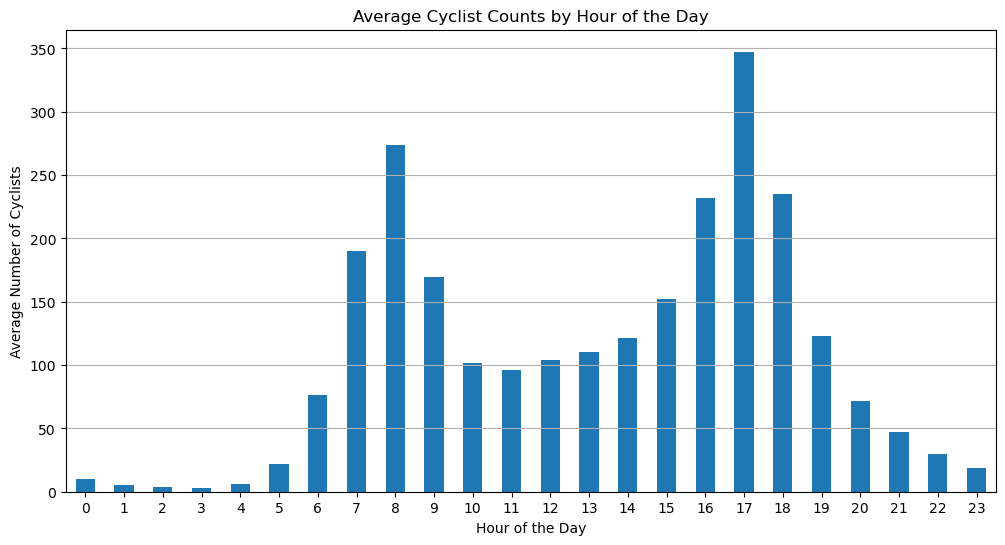

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by hour and calculate the mean
hourly_counts = df.groupby('Hour')['Total'].mean()

# Plot the average cyclist counts by hour
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar', title='Average Cyclist Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Cyclists')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

C:\Cache\ipykernel_11208\2500369704.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Data reloaded and prepared.


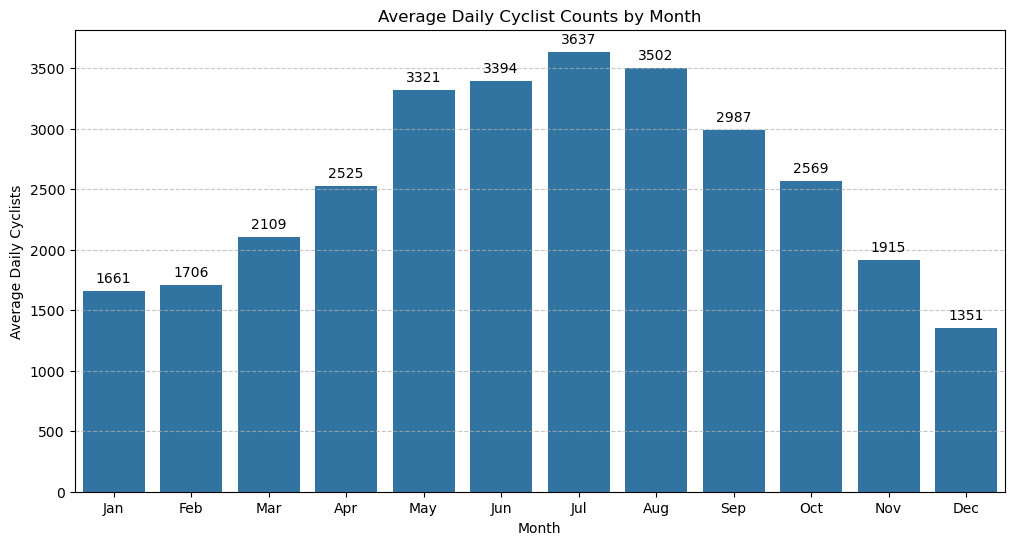

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# --- Data Reload and Preparation ---
df = pd.read_csv('Fremont_Bridge_Bicycle_Counter_20250715.csv', 
                 names=['Date', 'Total', 'West_Sidewalk', 'East_Sidewalk'], 
                 header=0)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)

for col in ['Total', 'West_Sidewalk', 'East_Sidewalk']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.fillna(0, inplace=True)
df['Total'] = df['Total'].astype(int)

# Add a 'Year' column for filtering
df['Year'] = df.index.year

print("Data reloaded and prepared.")
# --- Analysis Logic ---

# 1. Filter the DataFrame to include only the specified full years of data
# NOTE: The provided data only contains 2022, 2023, 2024, and 2025. 
# This code will effectively use 2022, 2023 and 2024.
years_to_exclude = [2012, 2025]
filtered_df = df[~df['Year'].isin(years_to_exclude)]

# 2. Resample to get total counts per day
daily_counts = filtered_df['Total'].resample('D').sum()

# 3. Group by month and calculate the average of the daily totals
monthly_avg = daily_counts.groupby(daily_counts.index.month).mean()

# 4. Map month numbers to abbreviated names for plotting
monthly_avg.index = monthly_avg.index.map(lambda x: calendar.month_abbr[x])

# Ensure the months are in chronological order for the plot
month_order = [calendar.month_abbr[i] for i in range(1, 13)]
monthly_avg = monthly_avg.reindex(month_order)

# --- Plotting ---
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=monthly_avg.index, y=monthly_avg.values)

# Add annotations (the exact number) on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title(f'Average Daily Cyclist Counts by Month')
plt.xlabel('Month')
plt.ylabel('Average Daily Cyclists')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

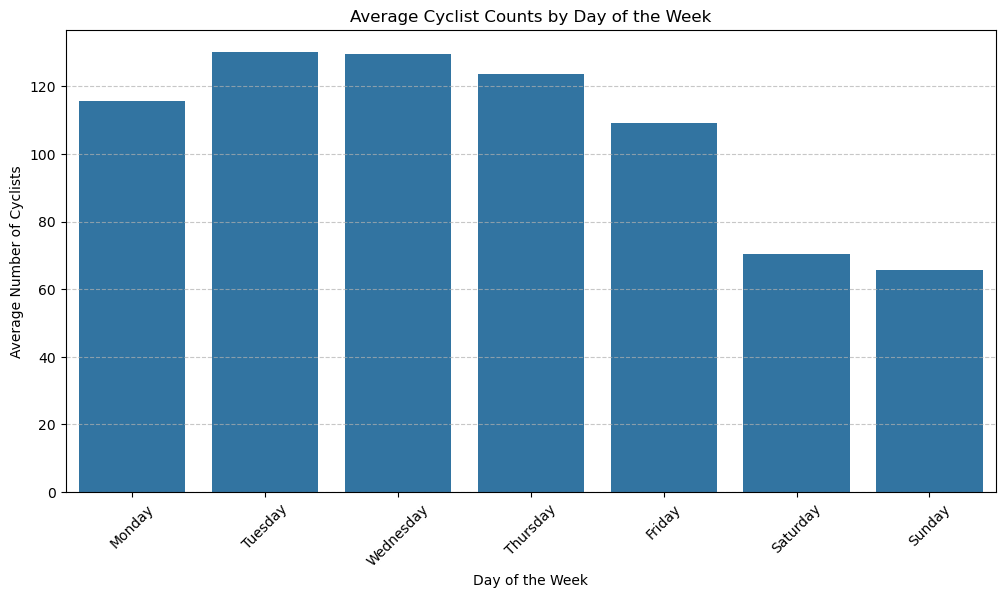

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the order of days for plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day of the week and calculate the mean
weekly_counts = df.groupby('Day_of_Week')['Total'].mean().reindex(day_order)

# Plot the average cyclist counts by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x=weekly_counts.index, y=weekly_counts.values)
plt.title('Average Cyclist Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Cyclists')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


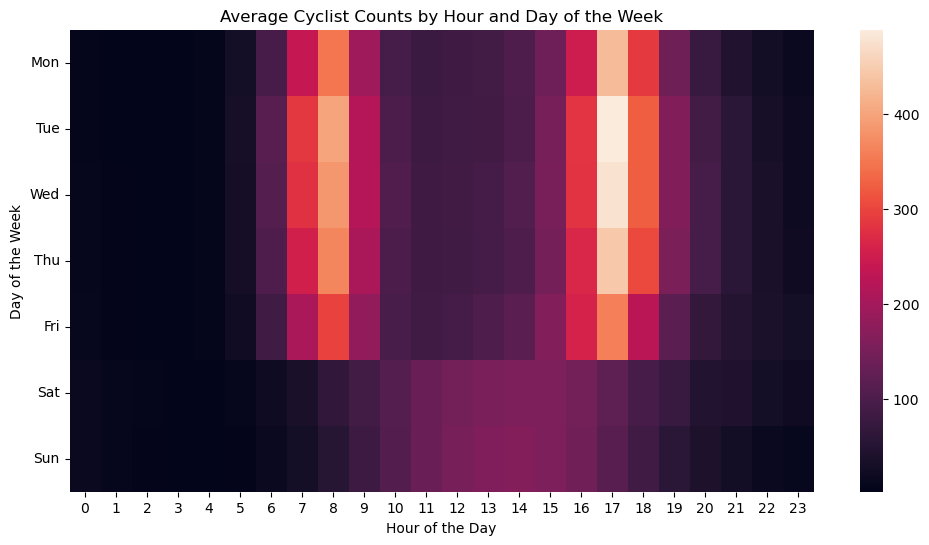

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the necessary time-based features for the pivot table
df['Hour'] = df.index.hour
df['Day_of_Week'] = df.index.strftime('%a')

# Create a pivot table to get average cyclist counts by hour and day of the week
heatmap_data = df.pivot_table(values='Total', index='Day_of_Week', columns='Hour', aggfunc='mean')

# Order the days of the week correctly
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_data = heatmap_data.reindex(day_order)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=False)  # Annotations removed for clarity on dense plot
plt.title('Average Cyclist Counts by Hour and Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.yticks(rotation=0) 
plt.show()


C:\Cache\ipykernel_11208\3741548554.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Data reloaded and prepared.


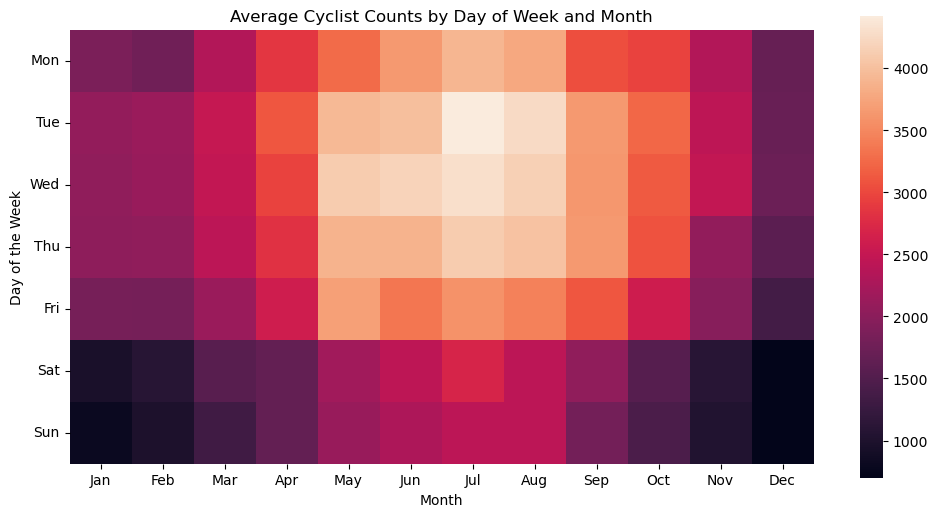

In [85]:
# --- Data Reload and Preparation ---
df = pd.read_csv('Fremont_Bridge_Bicycle_Counter_20250715.csv', 
                 names=['Date', 'Total', 'West_Sidewalk', 'East_Sidewalk'], 
                 header=0)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)
for col in ['Total', 'West_Sidewalk', 'East_Sidewalk']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.fillna(0, inplace=True)
df['Total'] = df['Total'].astype(int)
# Extract time-based features
df['Month'] = df.index.month
df['Day_of_Week'] = df.index.day_name()
# Add a 'Year' column for filtering
df['Year'] = df.index.year
print("Data reloaded and prepared.")
years_to_exclude = [2012, 2025]
filtered_df = df[~df['Year'].isin(years_to_exclude)]

# --- Analysis and Plotting ---
# 1. Resample to get the total count for each day first
daily_counts_df = filtered_df.resample('D').sum()
# Add month and day of week columns to the daily data
daily_counts_df['Month_Name'] = daily_counts_df.index.strftime('%b')
daily_counts_df['Day_of_Week'] = daily_counts_df.index.strftime('%a')

# 2. Create the pivot table: Days on the y-axis, Months on the x-axis
heatmap_data = daily_counts_df.pivot_table(values='Total', index='Day_of_Week', columns='Month_Name', aggfunc='mean')

# 3. Define the chronological order for both axes
month_order = [calendar.month_abbr[i] for i in range(1, 13)]
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_data = heatmap_data.reindex(index=day_order, columns=month_order)

# --- Plotting ---
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, square=True)
plt.title('Average Cyclist Counts by Day of Week and Month')
plt.xlabel('Month')
plt.ylabel('Day of the Week')
plt.yticks(rotation=0) 
plt.show()

C:\Cache\ipykernel_11208\477316339.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


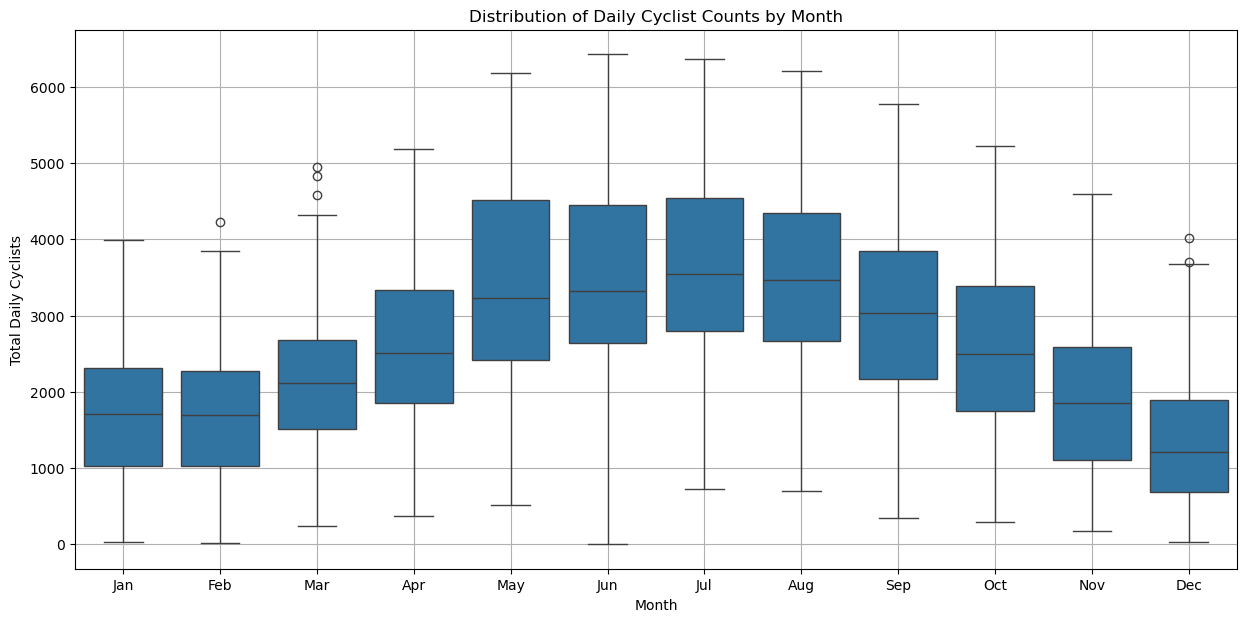

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# --- Data Reload and Preparation (Ensuring the DataFrame is ready) ---
df = pd.read_csv('Fremont_Bridge_Bicycle_Counter_20250715.csv', 
                 names=['Date', 'Total', 'West_Sidewalk', 'East_Sidewalk'], 
                 header=0)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)

for col in ['Total', 'West_Sidewalk', 'East_Sidewalk']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.fillna(0, inplace=True)

for col in ['Total', 'West_Sidewalk', 'East_Sidewalk']:
    df[col] = df[col].astype(int)

# --- Plotting Logic ---

# Resample to daily frequency
daily_df = df.resample('D').sum().reset_index()

# Get the month number from the Date
daily_df['Month'] = daily_df['Date'].dt.month

# Map month number to month abbreviation (e.g., 1 -> 'Jan')
daily_df['Month_Name'] = daily_df['Month'].apply(lambda x: calendar.month_abbr[x])

# Define the chronological order for the months
month_order = [calendar.month_abbr[i] for i in range(1, 13)]

# Create the box plot using month names and specifying the order
plt.figure(figsize=(15, 7))
sns.boxplot(x='Month_Name', y='Total', data=daily_df, order=month_order)
plt.title('Distribution of Daily Cyclist Counts by Month')
plt.xlabel('Month')
plt.ylabel('Total Daily Cyclists')
plt.grid(True)
plt.show()

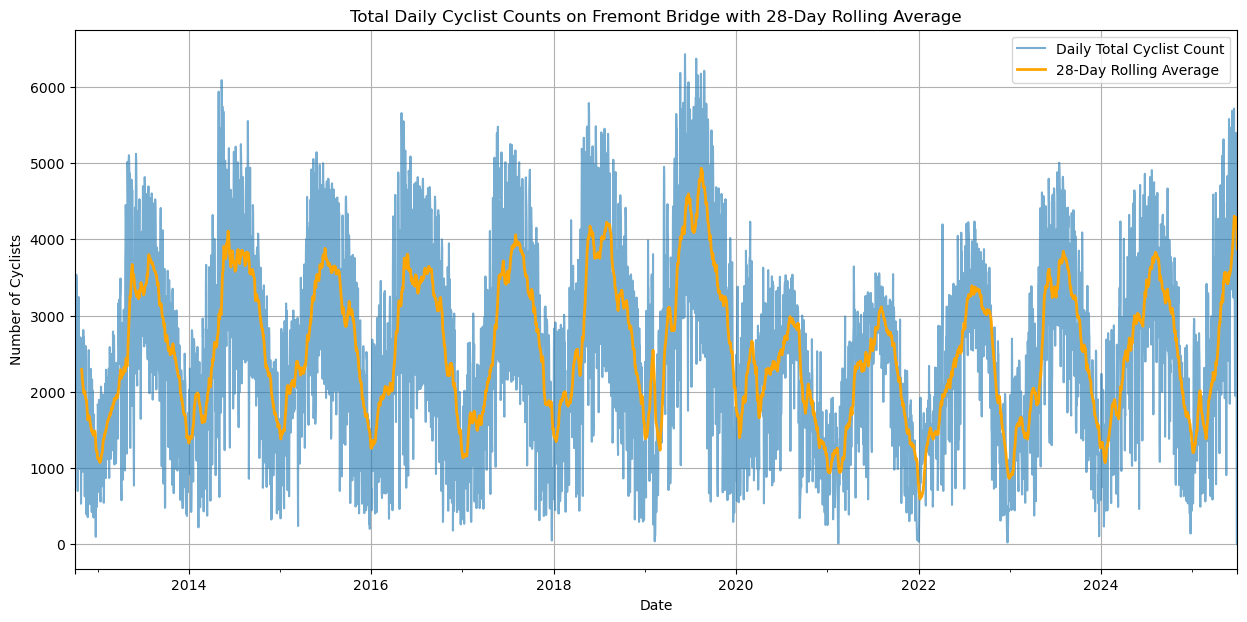

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Data Reload and Preparation ---

for col in ['Total', 'West_Sidewalk', 'East_Sidewalk']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.fillna(0, inplace=True)
df['Total'] = df['Total'].astype(int)

# --- Plotting with Rolling Average ---

# Resample to daily frequency and sum the counts
daily_counts = df['Total'].resample('D').sum()

# Calculate the 7-day rolling average
rolling_avg = daily_counts.rolling(window=28).mean()

# Plot both the daily counts and the rolling average
plt.figure(figsize=(15, 7))
daily_counts.plot(alpha=0.6, label='Daily Total Cyclist Count')
rolling_avg.plot(linewidth=2, label='28-Day Rolling Average', color='orange')

plt.title('Total Daily Cyclist Counts on Fremont Bridge with 28-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Number of Cyclists')
plt.legend()
plt.grid(True)
plt.show()

C:\Cache\ipykernel_11208\2240856963.py:4: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_counts = filtered_df['Total'].resample('A').sum()


Total Cyclist Counts Per Year:
Date
2013-12-31     928279
2014-12-31    1006196
2015-12-31     986502
2016-12-31     982470
2017-12-31     963135
2018-12-31    1051880
2019-12-31    1187146
2020-12-31     772593
2021-12-31     715630
2022-12-31     797537
2023-12-31     902926
2024-12-31     931637
Freq: YE-DEC


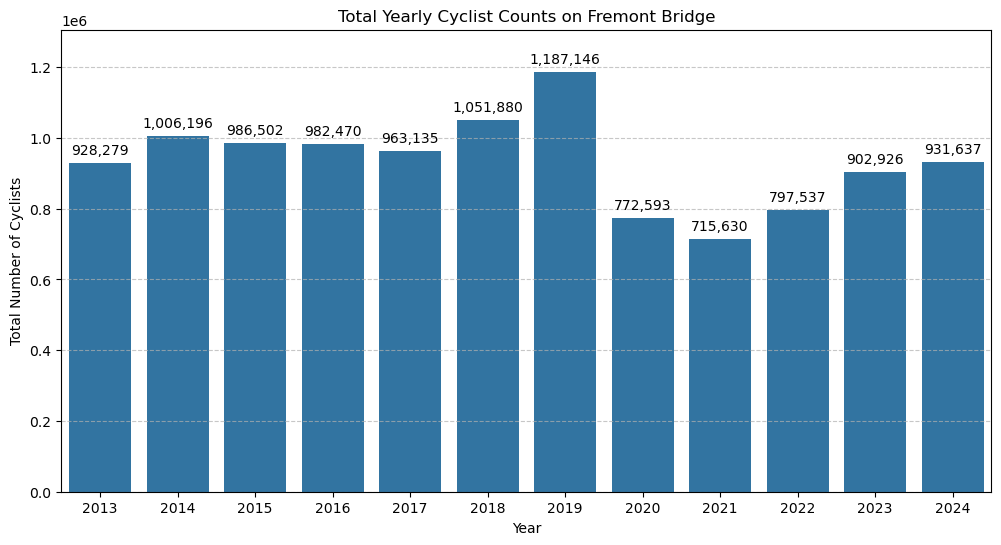

In [62]:
years_to_exclude = [2012, 2025]
filtered_df = df[~df['Year'].isin(years_to_exclude)]
# Resample the data by year and calculate the sum of total cyclists
yearly_counts = filtered_df['Total'].resample('A').sum()

# Print the yearly sums
print("Total Cyclist Counts Per Year:")
print(yearly_counts.to_string(name=False, dtype=False).replace('.0', ''))

# Create the bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=yearly_counts.index.year, y=yearly_counts.values)

# Add annotations (the exact number) on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Total Yearly Cyclist Counts on Fremont Bridge')
plt.xlabel('Year')
plt.ylabel('Total Number of Cyclists')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Ensure the y-axis starts at 0 for accurate visual comparison
plt.ylim(0, yearly_counts.max() * 1.1) 
plt.show()

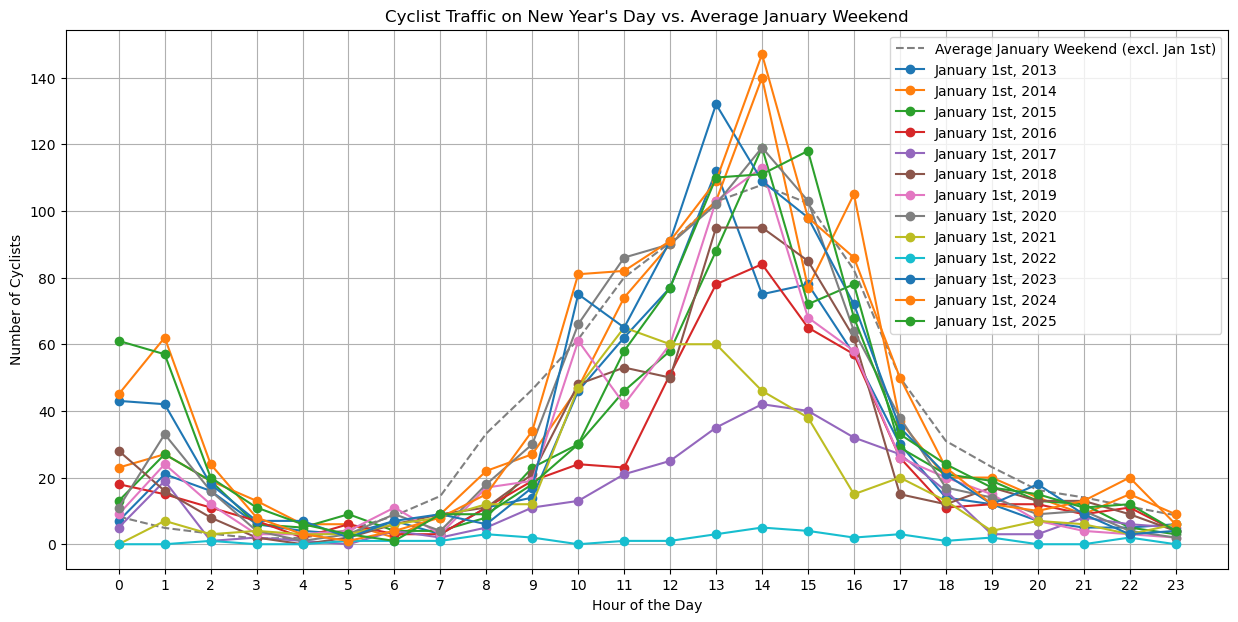

In [44]:
df['Hour'] = df.index.hour
df['Day_of_Week'] = df.index.day_name()
df['Year'] = df.index.year

# Filter for January 1st data across all available years
jan_1st_data = df[(df.index.month == 1) & (df.index.day == 1)]

# Filter for January weekends (Saturday or Sunday), excluding January 1st
january_weekends = df[
    (df.index.month == 1) & 
    (df['Day_of_Week'].isin(['Saturday', 'Sunday'])) &
    (df.index.day != 1)
]

# Calculate the average hourly traffic for these specific January weekend days
avg_jan_weekend_traffic = january_weekends.groupby('Hour')['Total'].mean()

# Plot the data
plt.figure(figsize=(15, 7))

# Plot the new average traffic for comparison
plt.plot(avg_jan_weekend_traffic.index, avg_jan_weekend_traffic.values, label='Average January Weekend (excl. Jan 1st)', linestyle='--', color='grey')

# Plot the actual traffic for each January 1st
for year in jan_1st_data['Year'].unique():
    yearly_data = jan_1st_data[jan_1st_data['Year'] == year]
    plt.plot(yearly_data['Hour'], yearly_data['Total'], marker='o', linestyle='-', label=f'January 1st, {year}')

plt.title('Cyclist Traffic on New Year\'s Day vs. Average January Weekend')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Cyclists')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

# 2023-2025 see spike around 1am


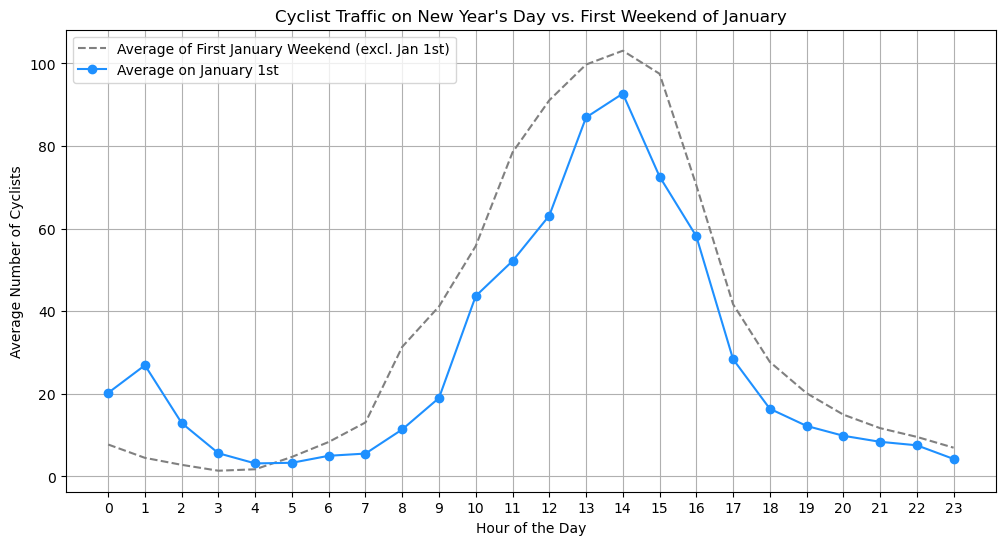

In [69]:
# 1. Calculate the average traffic for January 1st across all years (unchanged).
jan_1st_data = df[(df.index.month == 1) & (df.index.day == 1)]
avg_jan_1st_traffic = jan_1st_data.groupby('Hour')['Total'].mean()

# 2. Create the baseline: Average of the FIRST January weekend (Saturday & Sunday), excluding January 1st.
# Filter for all January weekends that are NOT the 1st of the month.
jan_weekends_mask = (
    (df.index.month == 1) & 
    (df['Day_of_Week_Num'] >= 5) & # Saturday=5, Sunday=6
    (df.index.day != 1)
)
jan_weekends_data = df[jan_weekends_mask]

# For each year, find the week number of the first weekend.
first_weekend_week_map = jan_weekends_data.groupby('Year')['Week_of_Year'].min()

# Create a boolean series to identify if a row belongs to the first weekend of its year
is_first_weekend = jan_weekends_data.apply(
    lambda row: row['Week_of_Year'] == first_weekend_week_map[row['Year']], 
    axis=1
)

# Filter down to only the data for the first weekend of each January
first_jan_weekend_data = jan_weekends_data[is_first_weekend]

# Calculate the average hourly traffic for this specific "first weekend" data
avg_first_jan_weekend_traffic = first_jan_weekend_data.groupby('Hour')['Total'].mean()


# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot the average traffic for the first January weekend
plt.plot(avg_first_jan_weekend_traffic.index, avg_first_jan_weekend_traffic.values, 
         label='Average of First January Weekend (excl. Jan 1st)', 
         linestyle='--', color='grey')

# Plot the average traffic for January 1st
plt.plot(avg_jan_1st_traffic.index, avg_jan_1st_traffic.values, 
         label='Average on January 1st', 
         marker='o', linestyle='-', color='dodgerblue')

plt.title("Cyclist Traffic on New Year's Day vs. First Weekend of January")
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Cyclists')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

Data from 2020 and 2021 has been excluded from the analysis.


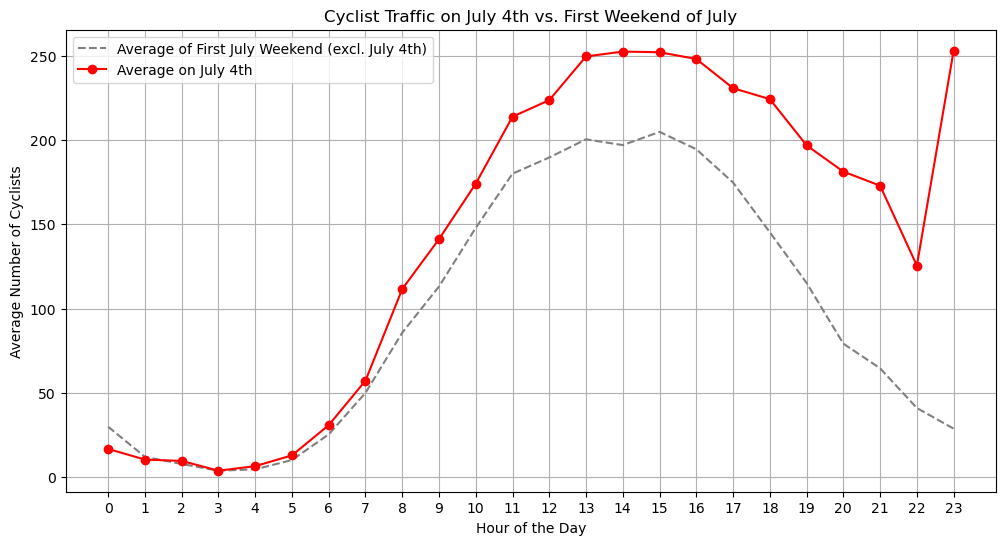

In [68]:
df['Week_of_Year'] = df.index.isocalendar().week # This is the added line

# --- ADDED LINE: Remove data from years 2020 and 2021 ---
df_non_pandemic = df[~df['Year'].isin([2020, 2021])]
print("Data from 2020 and 2021 has been excluded from the analysis.")


# --- Analysis Logic ---

# 1. Calculate the average traffic for July 4th across all years.
july_4th_data = df_non_pandemic[(df_non_pandemic.index.month == 7) & (df_non_pandemic.index.day == 4)]
avg_july_4th_traffic = july_4th_data.groupby('Hour')['Total'].mean()

# 2. Create the baseline: Average of the FIRST July weekend (Saturday & Sunday), excluding July 4th.
# Filter for all July weekends that are NOT the 4th of the month.
july_weekends_mask = (
    (df_non_pandemic.index.month == 7) & 
    (df_non_pandemic['Day_of_Week_Num'] >= 5) & # Saturday=5, Sunday=6
    (df_non_pandemic.index.day != 4)
)
july_weekends_data = df_non_pandemic[july_weekends_mask]

# For each year, find the first week that contains a weekend day.
first_weekend_week_map = july_weekends_data.groupby('Year')['Week_of_Year'].min()

# Create a boolean series to identify if a row belongs to the first weekend of its year
is_first_weekend = july_weekends_data.apply(
    lambda row: row['Week_of_Year'] == first_weekend_week_map[row['Year']], 
    axis=1
)

# Filter down to only the data for the first weekend of each July
first_july_weekend_data = july_weekends_data[is_first_weekend]

# Calculate the average hourly traffic for this specific "first weekend" data
avg_first_july_weekend_traffic = first_july_weekend_data.groupby('Hour')['Total'].mean()


# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot the average traffic for the first July weekend
plt.plot(avg_first_july_weekend_traffic.index, avg_first_july_weekend_traffic.values, 
         label='Average of First July Weekend (excl. July 4th)', 
         linestyle='--', color='grey')

# Plot the average traffic for July 4th
plt.plot(avg_july_4th_traffic.index, avg_july_4th_traffic.values, 
         label='Average on July 4th', 
         marker='o', linestyle='-', color='red')

plt.title("Cyclist Traffic on July 4th vs. First Weekend of July") #(2020 & 2021 Excluded)
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Cyclists')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

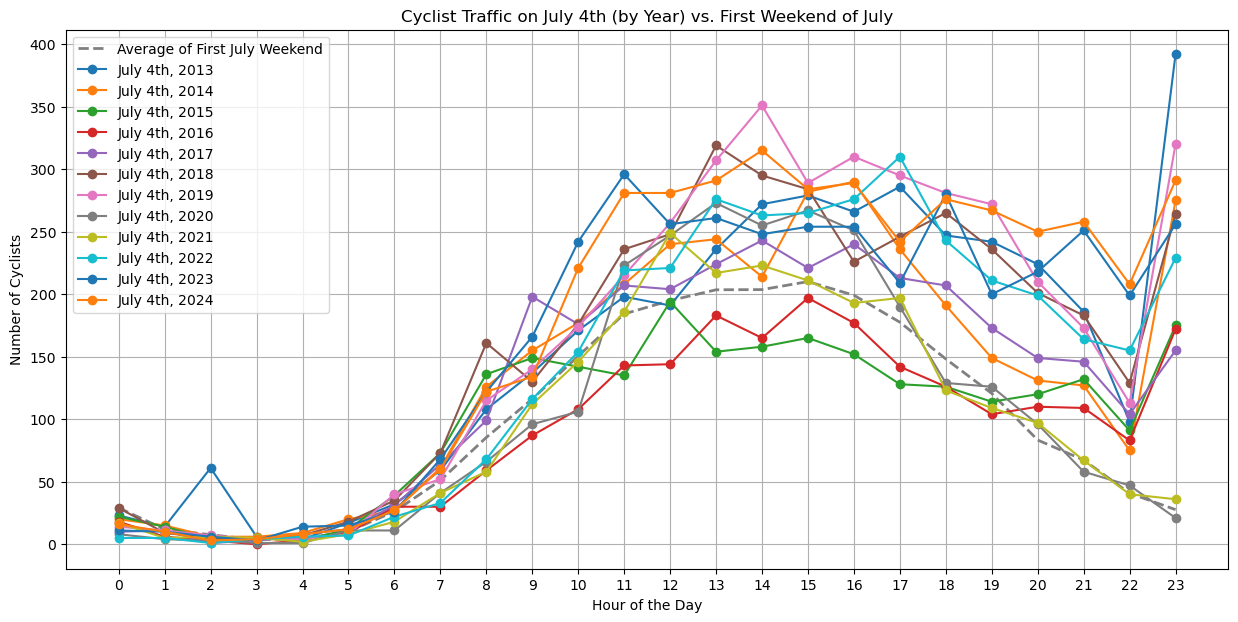

In [67]:
# 1. Filter for all July 4th data across all years.
july_4th_data = df[(df.index.month == 7) & (df.index.day == 4)]

# 2. Create the baseline: Average of the FIRST July weekend (Saturday & Sunday), excluding July 4th.
july_weekends_mask = (
    (df.index.month == 7) & 
    (df['Day_of_Week_Num'] >= 5) & # Saturday=5, Sunday=6
    (df.index.day != 4)
)
july_weekends_data = df[july_weekends_mask]

first_weekend_week_map = july_weekends_data.groupby('Year')['Week_of_Year'].min()

is_first_weekend = july_weekends_data.apply(
    lambda row: row['Week_of_Year'] == first_weekend_week_map[row['Year']], 
    axis=1
)
first_july_weekend_data = july_weekends_data[is_first_weekend]
avg_first_july_weekend_traffic = first_july_weekend_data.groupby('Hour')['Total'].mean()

# --- Plotting ---
plt.figure(figsize=(15, 7))

# Plot the baseline average traffic for the first July weekend
plt.plot(avg_first_july_weekend_traffic.index, avg_first_july_weekend_traffic.values, 
         label='Average of First July Weekend', 
         linestyle='--', color='grey', linewidth=2)

# Plot the traffic for each individual July 4th
for year in sorted(july_4th_data['Year'].unique()):
    yearly_data = july_4th_data[july_4th_data['Year'] == year]
    plt.plot(yearly_data['Hour'], yearly_data['Total'], 
             marker='o', linestyle='-', 
             label=f'July 4th, {year}')

plt.title("Cyclist Traffic on July 4th (by Year) vs. First Weekend of July")
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Cyclists')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

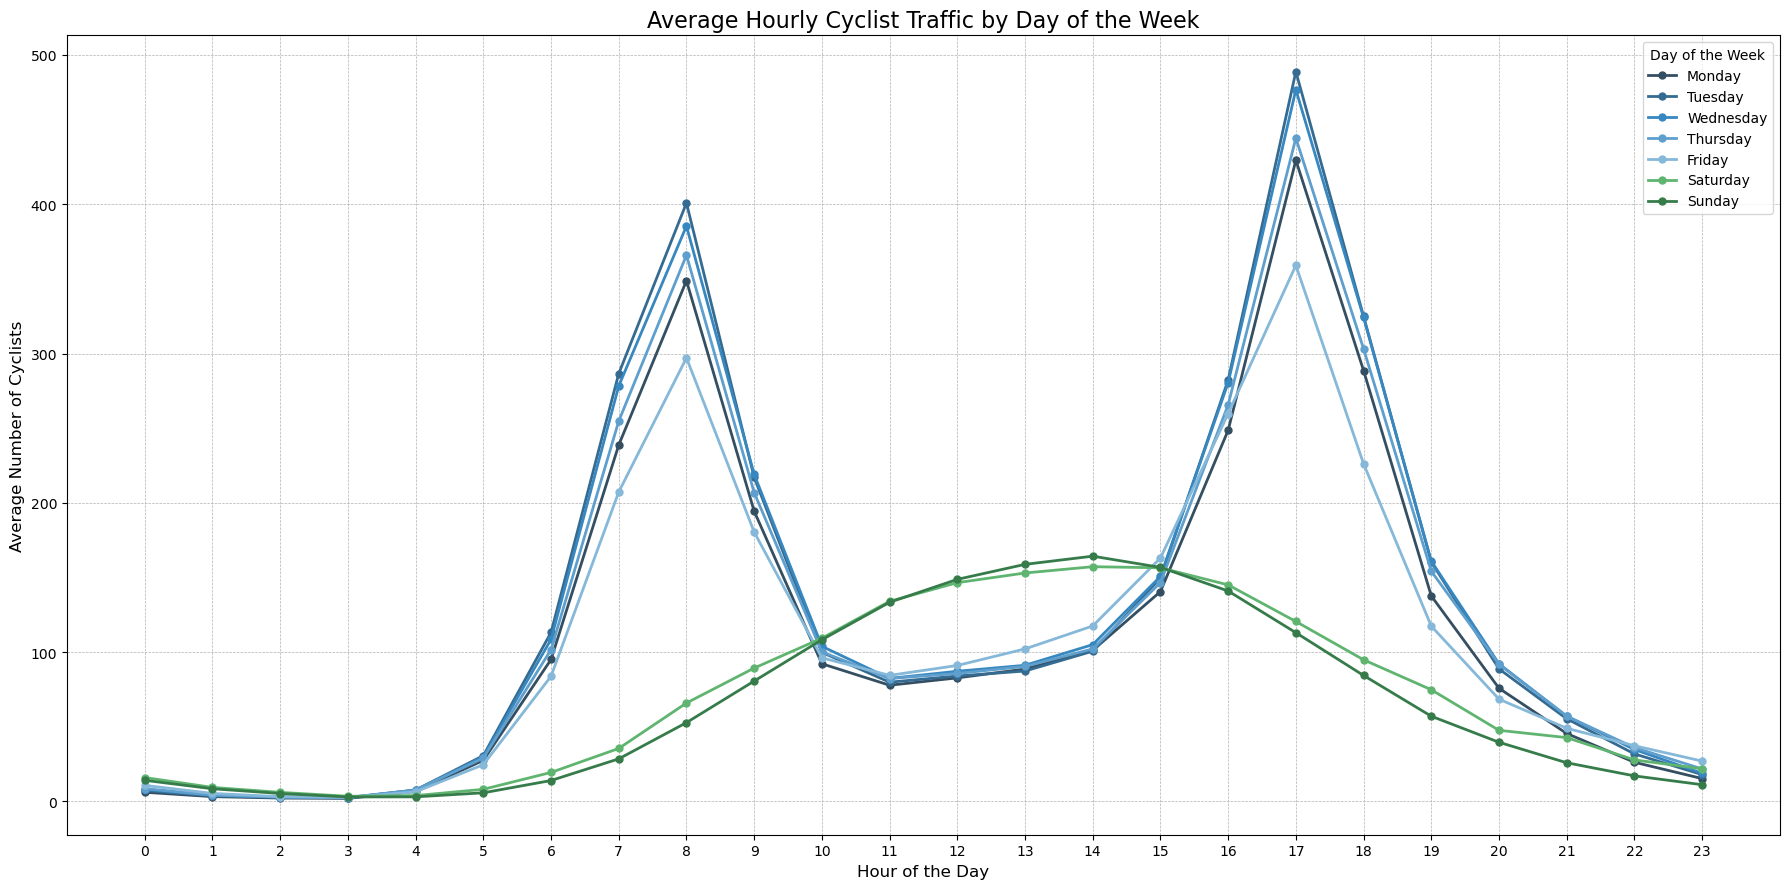

In [58]:
# Group by day and hour, and calculate the mean
hourly_weekly_avg = df.groupby(['Day_of_Week', 'Hour'])['Total'].mean()

# Unstack to create columns for each day
daily_patterns = hourly_weekly_avg.unstack(level='Day_of_Week')

# Order the columns chronologically
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_patterns = daily_patterns[day_order]

# --- Define the Custom Color Scheme ---
# 5 shades of blue for weekdays (reversed so Monday is lightest)
weekday_colors = sns.color_palette("Blues_d", n_colors=5)[::-1] 
# 2 shades of green for weekends
weekend_colors = sns.color_palette("Greens_d", n_colors=2)
# Combine the color lists
custom_palette = weekday_colors + weekend_colors

# Create the plot using the custom palette
plt.figure(figsize=(18, 9))
ax = daily_patterns.plot(kind='line', style='-o', 
                         color=custom_palette, 
                         ax=plt.gca(),
                         linewidth=2,
                         markersize=5)

# Set plot titles and labels
plt.title('Average Hourly Cyclist Traffic by Day of the Week', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Number of Cyclists', fontsize=12)

# Customize grid, ticks, and legend for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(range(0, 24))
plt.legend(title='Day of the Week')
plt.tight_layout()
plt.show()


Average Cyclist Counts Per Weekend Day:
Date
2012    246.02
2013    437.45
2014    446.28
2015    426.02
2016    379.13
2017    403.53
2018    427.95
2019    516.91
2020    553.20
2021    498.05
2022    517.37
2023    506.53
2024    518.54
2025    509.41


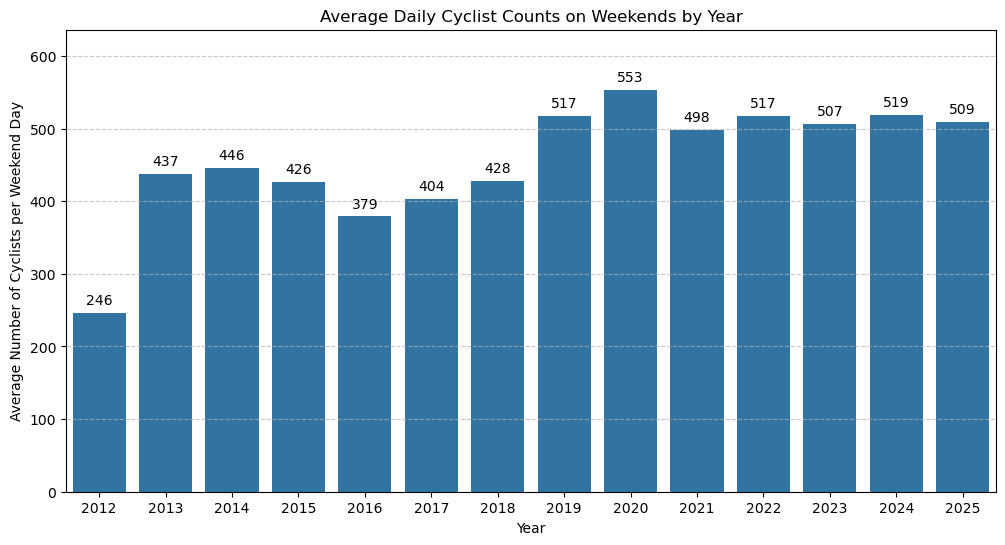

In [72]:
# 1. Filter for weekend data only (Saturday=5, Sunday=6)
weekend_df = df[df['Day_of_Week_Num'] >= 5].copy()

# 2. Resample the weekend data to get the total count for each day
daily_weekend_counts = weekend_df['Total'].resample('D').sum()

# 3. Group by year and calculate the mean of these daily counts
avg_yearly_weekend_counts = daily_weekend_counts.groupby(daily_weekend_counts.index.year).mean()

# Print the yearly averages
print("\nAverage Cyclist Counts Per Weekend Day:")
print(avg_yearly_weekend_counts.round(2).to_string(name=False, dtype=False))

# --- Plotting ---
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=avg_yearly_weekend_counts.index, y=avg_yearly_weekend_counts.values)

# Add annotations (the exact number) on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Average Daily Cyclist Counts on Weekends by Year')
plt.xlabel('Year')
plt.ylabel('Average Number of Cyclists per Weekend Day')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Ensure the y-axis starts at 0 for accurate visual comparison
plt.ylim(0, avg_yearly_weekend_counts.max() * 1.15) 
plt.show()

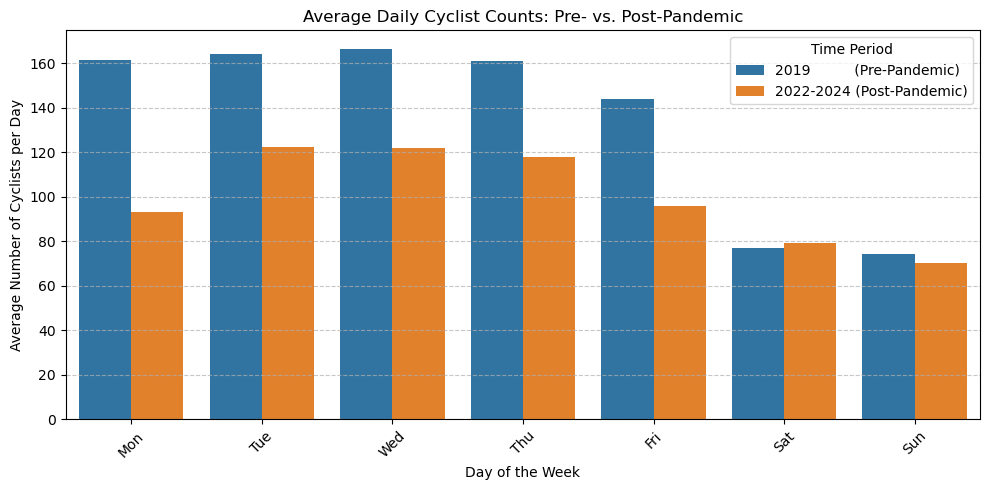

In [82]:
# --- Analysis Logic for Comparison ---

# 1. Define the two time periods
pre_pandemic_years = [2019]
post_pandemic_years = [2022, 2023, 2024]

# 2. Filter the DataFrame for each period
pre_pandemic_df = df[df['Year'].isin(pre_pandemic_years)]
post_pandemic_df = df[df['Year'].isin(post_pandemic_years)]

# 3. Calculate the average daily counts for each period
# Note: An if statement is included to prevent errors if the pre-pandemic data isn't in the file.
if not pre_pandemic_df.empty:
    avg_pre_pandemic = pre_pandemic_df.groupby('Day_of_Week')['Total'].mean().reset_index()
    avg_pre_pandemic['Period'] = '2019          (Pre-Pandemic)'
else:
    print("\nWarning: No data found for the years 2017-2019 in the provided file.")
    avg_pre_pandemic = pd.DataFrame() # Create empty dataframe to avoid errors

avg_post_pandemic = post_pandemic_df.groupby('Day_of_Week')['Total'].mean().reset_index()
avg_post_pandemic['Period'] = '2022-2024 (Post-Pandemic)'

# 4. Concatenate the results into a single DataFrame for plotting
comparison_df = pd.concat([avg_pre_pandemic, avg_post_pandemic], ignore_index=True)

# --- Plotting the Comparison ---
if not comparison_df.empty:
    # Define the order of days for plotting
    day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=comparison_df, x='Day_of_Week', y='Total', hue='Period', order=day_order)
    
    plt.title('Average Daily Cyclist Counts: Pre- vs. Post-Pandemic')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Number of Cyclists per Day')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Time Period')
    plt.tight_layout()
    plt.show()
else:
    print("Could not generate a comparison plot as data for one or both periods is missing.")

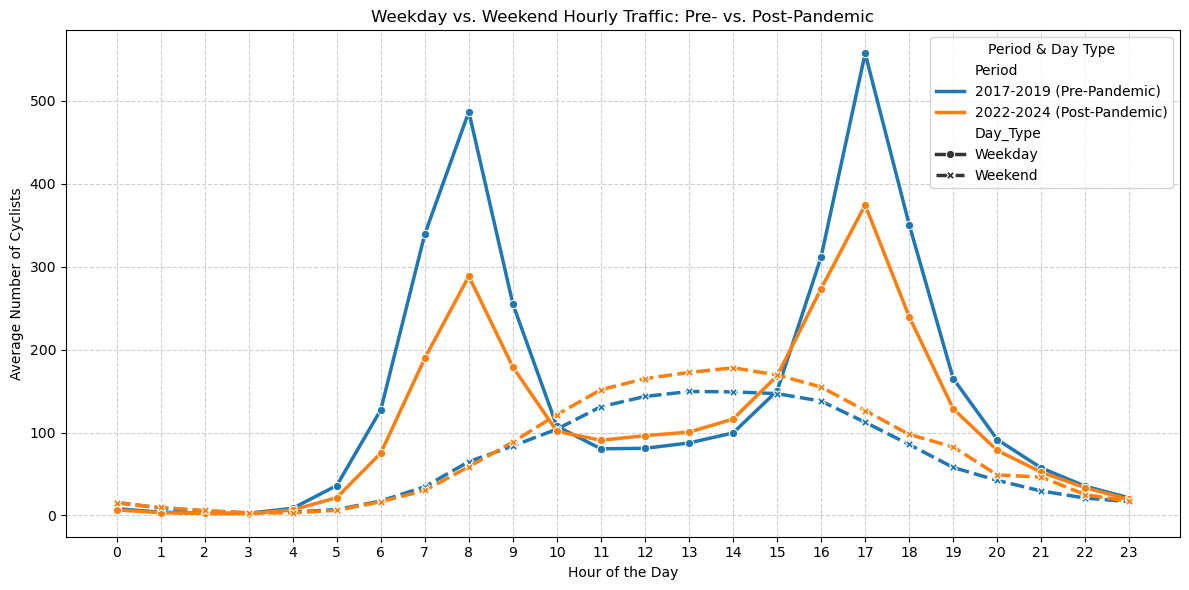

In [78]:
import numpy as np

# --- Analysis Logic for Comparison ---

# 1. Create a new column to categorize days as 'Weekday' or 'Weekend'
df['Day_Type'] = np.where(df['Day_of_Week_Num'] < 5, 'Weekday', 'Weekend')

# 2. Define the two time periods
pre_pandemic_years = [2017, 2018, 2019]
post_pandemic_years = [2022, 2023, 2024]

# 3. Filter the DataFrame for each period
pre_pandemic_df = df[df['Year'].isin(pre_pandemic_years)]
post_pandemic_df = df[df['Year'].isin(post_pandemic_years)]

# 4. Calculate the average hourly counts for Weekdays and Weekends in each period
all_averages = []

# Calculate pre-pandemic averages if data exists
if not pre_pandemic_df.empty:
    avg_pre_pandemic = pre_pandemic_df.groupby(['Day_Type', 'Hour'])['Total'].mean().reset_index()
    avg_pre_pandemic['Period'] = '2017-2019 (Pre-Pandemic)'
    all_averages.append(avg_pre_pandemic)
else:
    print("\nWarning: No data found for the years 2017-2019 in the provided file.")

# Calculate post-pandemic averages
if not post_pandemic_df.empty:
    avg_post_pandemic = post_pandemic_df.groupby(['Day_Type', 'Hour'])['Total'].mean().reset_index()
    avg_post_pandemic['Period'] = '2022-2024 (Post-Pandemic)'
    all_averages.append(avg_post_pandemic)

# 5. Concatenate the results into a single DataFrame for plotting
if all_averages:
    comparison_df = pd.concat(all_averages, ignore_index=True)
else:
    comparison_df = pd.DataFrame() # Ensure it's not empty

# --- Plotting the Comparison ---
if not comparison_df.empty:
    plt.figure(figsize=(12, 6))
    
    # Use seaborn's lineplot with hue for the period and style for the day type
    sns.lineplot(data=comparison_df, 
                 x='Hour', 
                 y='Total', 
                 hue='Period', 
                 style='Day_Type', 
                 markers=True, 
                 linewidth=2.5)
    
    plt.title('Weekday vs. Weekend Hourly Traffic: Pre- vs. Post-Pandemic')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Number of Cyclists')
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Period & Day Type')
    plt.tight_layout()
    plt.show()
else:
    print("Could not generate a comparison plot as data for both periods is missing.")

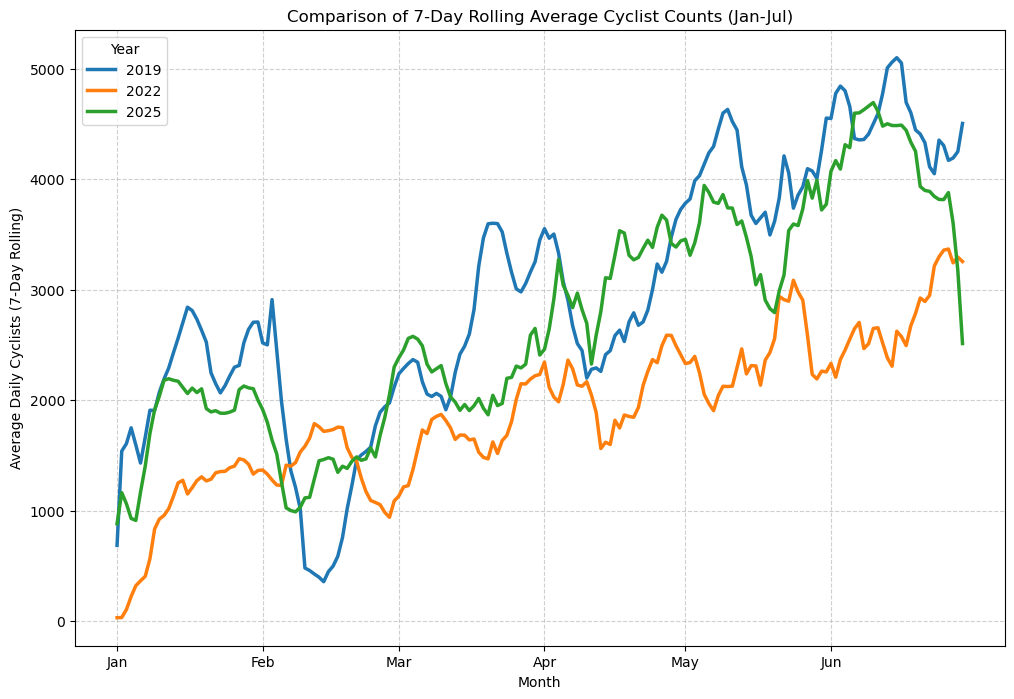

In [90]:
# 1. Define the specific years and months for the analysis
years_to_compare = [2019, 2022, 2025]
months_to_include = range(1, 7) # January to July

# 2. Create a dictionary to hold the rolling average data for each year
yearly_trends = {}
years_found = []

for year in years_to_compare:
    # Filter for the current year and the specified months
    year_data = df[(df['Year'] == year) & (df.index.month.isin(months_to_include))]
    
    # Proceed only if data for that year exists
    if not year_data.empty:
        years_found.append(year)
        # Resample to daily totals to ensure a value for every day
        daily_year_data = year_data['Total'].resample('D').sum()
        # Calculate the 7-day rolling average
        rolling_avg = daily_year_data.rolling(window=7, min_periods=1).mean()
        yearly_trends[year] = rolling_avg

# --- Plotting the Comparison ---
if yearly_trends:
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Plot the 7-day rolling average for each year
    for year, data in yearly_trends.items():
        # Use dayofyear for a common x-axis
        ax.plot(data.index.dayofyear, data.values, label=f'{year}', linewidth=2.5)

    # --- Customize X-axis to show Month Names ---
    # Define tick positions for the first day of each month
    month_starts = [pd.Timestamp(f'2024-{m}-01').dayofyear for m in months_to_include]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
    
    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_names)

    # Set plot titles and labels
    plt.title(f'Comparison of 7-Day Rolling Average Cyclist Counts (Jan-Jul)')
    plt.xlabel('Month')
    plt.ylabel('Average Daily Cyclists (7-Day Rolling)')
    plt.legend(title='Year')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("\nNo data found for the specified years (2019, 2022, 2025) in the January-July period.")

C:\Cache\ipykernel_11208\1140147326.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Data reloaded and prepared.

Average Cyclist Counts per Summer Weekend Day (Jun-Aug):
Year
2013    2385
2014    2318
2015    2060
2016    2016
2017    2219
2018    2216
2019    2889
2020    2766
2021    2510
2022    2672
2023    2624
2024    2682


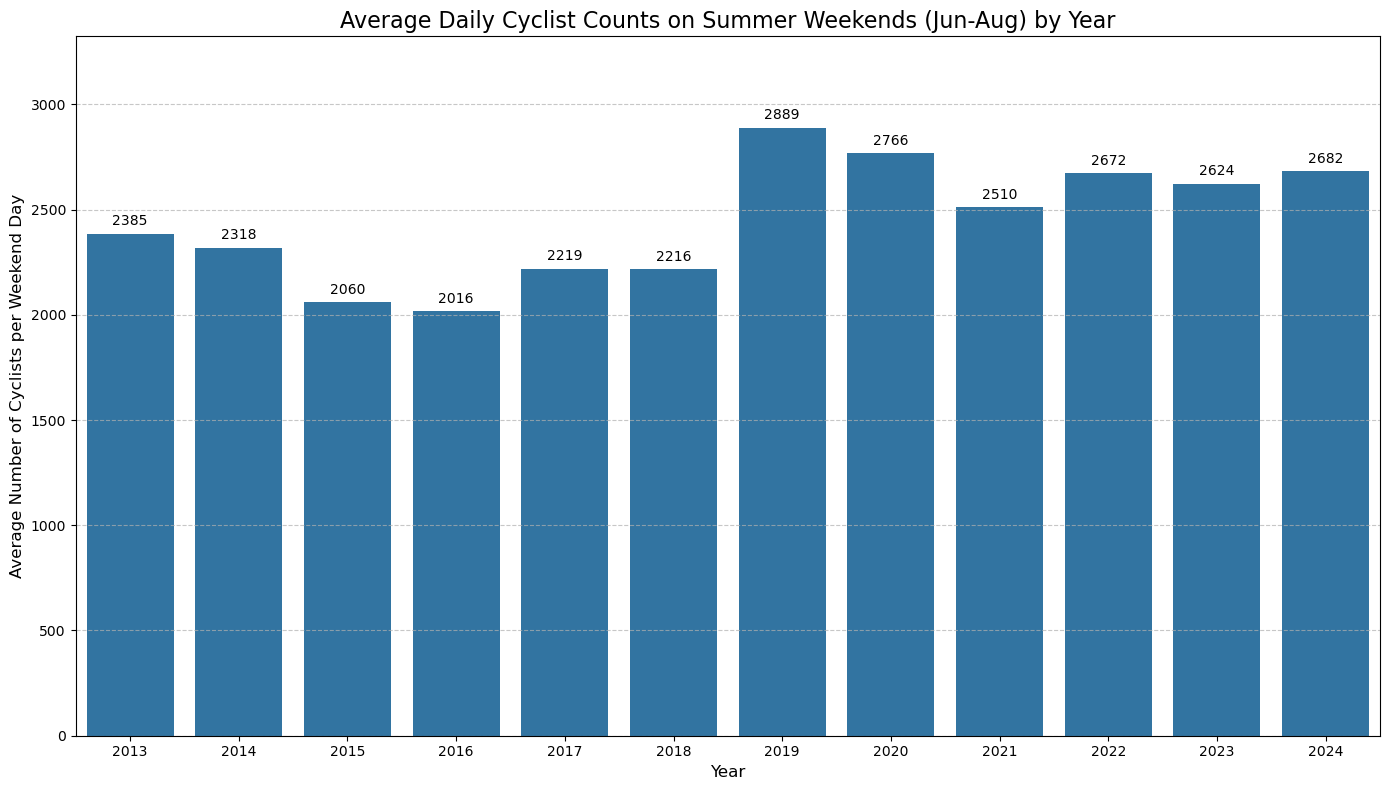

In [92]:
# --- Data Reload and Preparation ---
df = pd.read_csv('Fremont_Bridge_Bicycle_Counter_20250715.csv', 
                 names=['Date', 'Total', 'West_Sidewalk', 'East_Sidewalk'], 
                 header=0)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)

for col in ['Total', 'West_Sidewalk', 'East_Sidewalk']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.fillna(0, inplace=True)
df['Total'] = df['Total'].astype(int)

print("Data reloaded and prepared.")

# --- Analysis Logic ---

# 1. First, resample the hourly data to get daily totals
daily_df = df.resample('D').sum()

# 2. Add helper columns to the new daily DataFrame
daily_df['Year'] = daily_df.index.year
daily_df['Month'] = daily_df.index.month
daily_df['Day_of_Week_Num'] = daily_df.index.dayofweek  # Monday=0, Sunday=6

# 3. Define the time periods and filter the daily data
years_to_include = range(2013, 2025)  # Includes 2013 up to 2024
months_to_include = [6, 7, 8]       # June, July, August

summer_weekend_mask = (
    daily_df['Year'].isin(years_to_include) &
    daily_df['Month'].isin(months_to_include) &
    (daily_df['Day_of_Week_Num'] >= 5)  # Saturday=5, Sunday=6
)
filtered_daily_df = daily_df[summer_weekend_mask]

# 4. Group by year and calculate the mean of the daily totals
avg_summer_weekend_counts = filtered_daily_df.groupby('Year')['Total'].mean()

# --- Display the Results ---

print("\nAverage Cyclist Counts per Summer Weekend Day (Jun-Aug):")
# Print a formatted string, rounding to the nearest whole number
print(avg_summer_weekend_counts.round(0).to_string(name=False, dtype=False).replace('.0', ''))

# Plotting the comparison
if not avg_summer_weekend_counts.empty:
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x=avg_summer_weekend_counts.index, y=avg_summer_weekend_counts.values)

    # Add annotations
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')

    plt.title('Average Daily Cyclist Counts on Summer Weekends (Jun-Aug) by Year', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Number of Cyclists per Weekend Day', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, avg_summer_weekend_counts.max() * 1.15)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo data available for the specified years (2013-2024) to generate a plot.")